In [88]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Added import for LabelEncoder

In [89]:
# Step 1: Load the CSV dataset
def load_data(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)
    data = data.sample(frac=0.5, random_state=42)  # Shuffle data
    return data

# Step 2: Prepare the dataset for 1D CNN
def prepare_data(data):
    # Select only the required columns
    selected_columns = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']
    data = data[selected_columns]
    
    # Handle missing values if any (you can choose to drop or impute)
    data = data.dropna()  # Dropping rows with missing values for simplicity

    label_col = 'Label'  # Specify label column

    # Features are all columns except 'Label'
    feature_columns = data.columns.difference([label_col]).tolist()

    features = data[feature_columns].values.astype(np.float32)

    # Encode labels as integers
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data[label_col].values)

    return features, labels

# Step 3: Create a custom PyTorch Dataset class
class DDoSDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension

In [90]:
# Step 4: Load data, split into train, validation, and test sets
data = load_data("/Users/book_kuno/Downloads/DDoS 2018/02-21-2018.csv")
features, labels = prepare_data(data)

train_feats, test_feats, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
train_feats, val_feats, train_labels, val_labels = train_test_split(train_feats, train_labels, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = DDoSDataset(train_feats, train_labels)
val_dataset = DDoSDataset(val_feats, val_labels)
test_dataset = DDoSDataset(test_feats, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [91]:
# Step 5: Define the 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (input_size // 2 // 2), 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [92]:
# Step 6: Initialize model, loss, and optimizer
input_size = features.shape[1]
num_classes = len(set(labels))

model = CNN1D(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
# Step 7: Train and Validate the model
def trainAndValidate_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    return model

model = trainAndValidate_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 520.0872080780498
Epoch 2/10, Loss: 0.04240371850118426
Epoch 3/10, Loss: 8.037317266046765
Epoch 4/10, Loss: 0.02562807851536775
Epoch 5/10, Loss: 0.21559649715692053
Epoch 6/10, Loss: 0.0499904930902705
Epoch 7/10, Loss: 0.03496737404190087
Epoch 8/10, Loss: 0.1510223540559698
Epoch 9/10, Loss: 0.025727919318012757
Epoch 10/10, Loss: 0.02802696162304977


In [94]:
# Step 8: Evaluate on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []  # To store true labels
    y_pred = []  # To store predicted labels

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append the current batch's true and predicted labels to the lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return y_true, y_pred

# Get the true and predicted labels
y_true, y_pred = evaluate_model(model, test_loader)

Test Accuracy: 99.57%


In [95]:
#V1:Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     36178
           1       0.99      1.00      1.00     68514
           2       0.00      0.00      0.00       166

    accuracy                           1.00    104858
   macro avg       0.66      0.66      0.66    104858
weighted avg       0.99      1.00      0.99    104858



/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


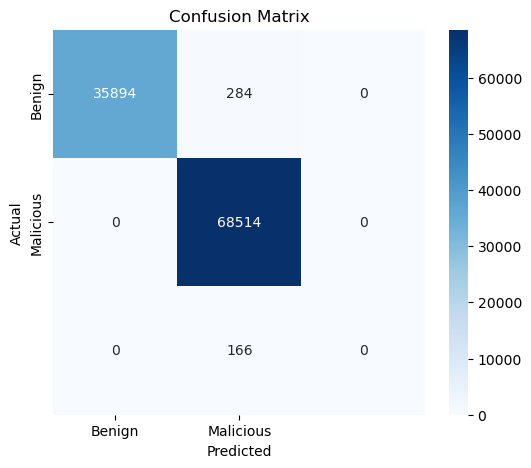

In [96]:
#V2:Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already obtained y_true and y_pred from the evaluate_model function
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])

# Adding labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

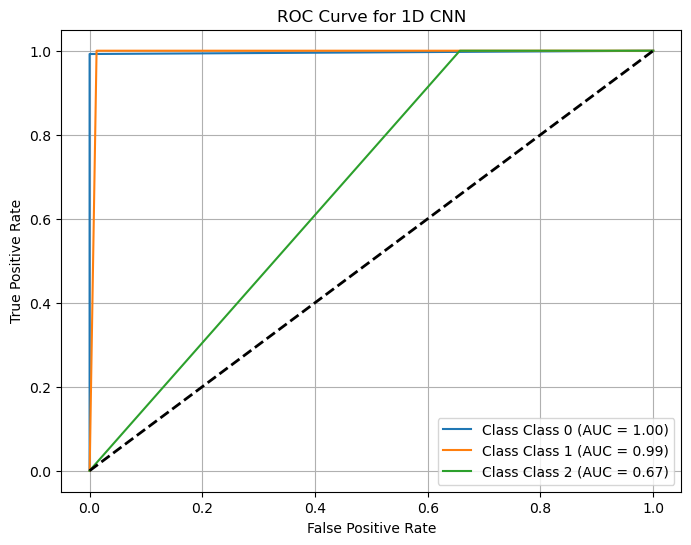

In [97]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained model 'cnn_model' and test data loaded in 'test_loader'
# 'y_true' corresponds to the ground truth labels for the test set.
# 'y_pred_prob' corresponds to the predicted probabilities from your CNN model.

def get_predictions_and_probabilities(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get model predictions (logits)
            prob = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            y_true.extend(labels.cpu().numpy())  # Convert to CPU and append to y_true list
            y_pred_prob.extend(prob.cpu().numpy())  # Convert to CPU and append to predicted probabilities

    # Convert y_pred_prob list to a NumPy array
    y_pred_prob = np.array(y_pred_prob)

    return y_true, y_pred_prob

# Get true labels and predicted probabilities
y_true, y_pred_prob = get_predictions_and_probabilities(model, test_loader, device)

# Plot ROC curves for each class
class_names = ['Class 0', 'Class 1', 'Class 2']  # Modify this to your class names
plt.figure(figsize=(8, 6))

# Loop over each class and calculate the ROC curve
for i in range(y_pred_prob.shape[1]):  # Loop over each class
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")  # Plot the ROC curve for each class

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line (random classifier)
plt.title("ROC Curve for 1D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()